In [10]:
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Looking at real data of pneumonia x-ray images used with CNNs. Data from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# Data includes bacterial and viral pneumonia = the firal version being critical to development of COVID19
# These are grayscale images!

In [11]:
# Set working directory
dir = '/Users/kieranodonnell/Documents/GitHub/Data_Sci/Datasets/chest_xray'

In [12]:
os.listdir(dir)

['.DS_Store', 'test', 'train', 'val']

In [4]:
# Outlining the training/test/val

test_dir = dir+'/test/'
train_dir = dir+'/train/'
val_dir = dir+'/val/'

In [5]:
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [6]:
os.listdir(test_dir)

['PNEUMONIA', 'NORMAL']

In [7]:
os.listdir(val_dir)

['PNEUMONIA', 'NORMAL']

In [8]:
# Lables are PNEUMONIA and NORMAL

In [9]:
# Looking at single image
os.listdir(train_dir+'PNEUMONIA')[404]

'person1293_virus_2219.jpeg'

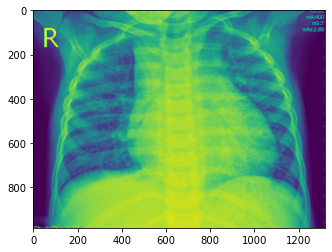

In [10]:
pneumonic_lung = train_dir+'PNEUMONIA/'+'person1293_virus_2219.jpeg'
plt.imshow(imread(pneumonic_lung))

In [11]:
# Looking at single image
os.listdir(train_dir+'NORMAL')[404]

'IM-0469-0001.jpeg'

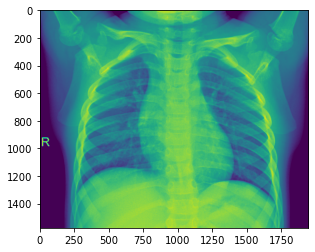

In [12]:
non_pneumonic_lung = train_dir+'NORMAL/'+'IM-0469-0001.jpeg'
plt.imshow(imread(non_pneumonic_lung))

In [13]:
# Can see difference between pneumonic and normal lung -> pneumonia shows a cloudy-like structure in the lungs

In [14]:
# Looking at shapes

imread(pneumonic_lung).shape

(984, 1320)

In [15]:
# Looking at shapes

imread(non_pneumonic_lung).shape

(1576, 1948)

In [16]:
# Finding numbers
len(os.listdir(train_dir+'NORMAL'))

1341

In [17]:
len(os.listdir(train_dir+'PNEUMONIA'))

3875

In [18]:
len(os.listdir(test_dir+'NORMAL'))

234

In [19]:
len(os.listdir(test_dir+'PNEUMONIA'))

390

In [20]:
len(os.listdir(val_dir+'NORMAL'))

8

In [21]:
len(os.listdir(val_dir+'PNEUMONIA'))

8

In [22]:
# Greater number of pneumoic images for train and test sets, while only 8 for each in validation set

In [23]:
# All images are a different size!
x_dim = []
y_dim = []

for image_file in os.listdir(train_dir+'NORMAL'):
    img = imread(train_dir+'NORMAL/'+image_file)
    x_dims, y_dims = img.shape
    x_dim.append(x_dims)
    y_dim.append(y_dims)

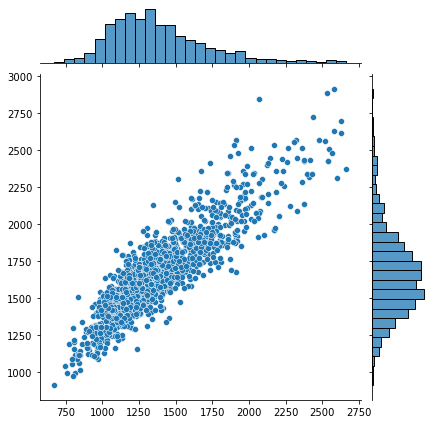

In [24]:
# Looking at historgame of image dimensions
sns.jointplot(x=x_dim, y = y_dim)

In [25]:
# Resize all images to make them same size. Will choose average size whhc is around 131x131
print(np.mean(x_dim), np.mean(y_dim))


1381.4310216256524 1667.7345264727815


In [26]:
# Will use 1280 x 1280 -> around mean size
image_shape = (1280,1280)

In [27]:
# Data processing - this model will have batch processing -> images are rather large. Will also add random rotations etc

img_data_gen = ImageDataGenerator(rotation_range = 45,
                                 width_shift_range=0.25,
                                 height_shift_range=0.25,
                                 rescale = 1./255,
                                 shear_range=0.25,
                                 zoom_range=0.25,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest',)

In [28]:
# Defining data generators for feeding from directory to the CNN in batches

train_generator  = img_data_gen.flow_from_directory(
                             train_dir,
                             target_size = image_shape,
                             batch_size =32 ,               
                             class_mode = 'binary',
                            )

test_generator = img_data_gen.flow_from_directory(
                             test_dir,
                             target_size = image_shape,
                             batch_size = 32 ,               
                             class_mode = 'binary',
                            )

validation_generator = img_data_gen.flow_from_directory(
                             val_dir,
                             target_size = image_shape,
                             batch_size = 32 ,               
                             class_mode = 'binary',
                            )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [29]:
# Model definition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from datetime import datetime

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (4,4), input_shape = (1280,1280,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4), input_shape = (1280,1280,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), input_shape = (1280,1280,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1277, 1277, 16)    784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 638, 638, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 635, 635, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 317, 317, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 314, 314, 64)      32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 157, 157, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1577536)           0

In [30]:
# Geting tensorboard set up

timestamp = datetime.now().strftime("%d/%m/%Y, %H:%M:%S")

# Define TBoard and directory

log_directory = 'logs/fit'
log_directory = log_directory+'/'+timestamp

board = TensorBoard(log_dir = log_directory,
                   histogram_freq = 1,
                   write_graph = True,
                   write_images = True,
                   update_freq = 'epoch',
                   profile_batch = 2,
                   embeddings_freq = 1)

In [31]:
# Define early call backs

earlystop_callback = EarlyStopping(monitor='val_loss', patience=2, mode = 'min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='auto')

In [ ]:
# Final model

final_model = model.fit_generator(train_generator,
              epochs=50,
              validation_data=validation_generator, 
              callbacks=[earlystop_callback,learning_rate_reduction,board],
              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
  1/163 [..............................] - ETA: 0s - loss: 0.6787 - accuracy: 0.6250